# Influence of COVID-19 on CMU Pittsburgh Campus Energy Utilization

### Loading the data

Data is loaded from three Comma Separated Value (CSV) files that contain measurements of electrical usage measured at different campus buildings during the last year.
as a single Pandas Data Frame with fields: Timestamp, Meter 1, Meter 2, ..., Meter $N$. Where the $N$ meters are the real power measurements as reported in the CSV file.
#### Data available from 31 March 2019 - 31 March 2020. (COVID influences on energy consumption can be observed from the start of March 2020)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import itertools
from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
def loadDatabaker():
    baker = open('data/baker.csv')
    data_baker = pd.read_csv(baker,sep=',', names=["Timestamp", "baker"], parse_dates=[1])
    data_baker['Timestamp'] = pd.to_datetime(data_baker['Timestamp'])
    data_baker['baker'] = pd.to_numeric(data_baker['baker'], errors = 'coerce')
    data_baker.drop_duplicates(subset=['Timestamp'], inplace=True)
    return data_baker
def loadDatacampus():
    campus = open('data/campus-electric-pp1.csv')
    data_campus = pd.read_csv(campus,sep=',', names=["Timestamp", "campus"], parse_dates=[1])
    data_campus['Timestamp'] = pd.to_datetime(data_campus['Timestamp'])
    data_campus['campus'] = pd.to_numeric(data_campus['campus'], errors = 'coerce')
    data_campus.drop_duplicates(subset=['Timestamp'], inplace=True)
    return data_campus
def loadDatacfa():
    cfa = open('data/cfa.csv')
    data_cfa = pd.read_csv(cfa,sep=',', names=["Timestamp", "cfa"], parse_dates=[1])
    data_cfa['Timestamp'] = pd.to_datetime(data_cfa['Timestamp'])
    data_cfa['cfa'] = pd.to_numeric(data_cfa['cfa'], errors = 'coerce')
    data_cfa.drop_duplicates(subset=['Timestamp'], inplace=True)
    return data_cfa
def mergeall(data_baker, data_campus, data_cfa):
    df_merge1 = data_baker.merge(data_campus, how='inner', on ="Timestamp")
    df_merge = df_merge1.merge(data_cfa, how='inner', on ="Timestamp")
    df_merge
    return df_merge

In [4]:
data_baker = loadDatabaker()

data_campus = loadDatacampus()

data_cfa = loadDatacfa()

df = mergeall(data_baker, data_campus, data_cfa)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527700 entries, 0 to 527699
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Timestamp  527700 non-null  datetime64[ns]
 1   baker      517459 non-null  float64       
 2   campus     527346 non-null  float64       
 3   cfa        527521 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 20.1 MB


In [17]:
df.head() #Data from Baker Hall, College of Fine Arts(CFA) and Campus Mains (all halls combined)

Timestamp        baker       campus          cfa  Hour  Weekday  \
0 2019-03-31 00:00:00  140507.4375  1627888.125  116484.8750     0        6   
1 2019-03-31 00:01:00  141281.3594  1650316.250  115423.2656     0        6   
2 2019-03-31 00:02:00  140535.7500  1656852.125  113892.2109     0        6   
3 2019-03-31 00:03:00  141794.1094  1640444.500  112843.6406     0        6   
4 2019-03-31 00:04:00  141737.0938  1635293.875  114116.1563     0        6   

   DayOfYear  
0         90  
1         90  
2         90  
3         90  
4         90

### Cleaning up the data

Visualizing the data and checking for common problems that would warrant some cleaning processes (e.g., removal of outliers, filling in/imputing missing data, aligning the time series, etc.).

### Observation

I found that for all building data - baker, campus and cfa, some timestamps didn't have coresponding readings (but rather 'I/O timeout').
Also, some timestamps (like "2019-11-03 01:45:00") had duplicate readings.
So, for such values, the reading error was replaced with NaN and duplicate values were dropped while parsing during the previous step.
<br />
In this step: <br />
Firstly, threshold = np.mean(df["Reading"]) - 2*np.std(df["Reading"]) is calculated
Then, values below these threshold are changed to NaN
Finally, each of these NaN values (including missing to NaN converted values) are replaced with a linearly interpolated value.

In [8]:
def cleanData(df):
    # hard thresholding
    # in this case we prohibit values smaller than 2 stds
    threshold = np.mean(df["Reading"]) - 2*np.std(df["Reading"])
    df["Reading"].values[df["Reading"] < threshold] = np.nan
    df = df.interpolate(method='linear')
    return df
def clean_baker(data_baker):
    data_in = data_baker
    df = data_in.rename(columns = {"baker":"Reading"})
    data_clean = cleanData(df)
    data_clean.rename(columns = {"Reading":"baker"}, inplace = True)
    return data_clean
def clean_campus(data_campus):
    data_in = data_campus
    df = data_in.rename(columns = {"campus":"Reading"})
    data_clean = cleanData(df)
    data_clean.rename(columns = {"Reading":"campus"}, inplace = True)
    return data_clean
def clean_cfa(data_cfa):
    data_in = data_cfa
    df = data_in.rename(columns = {"cfa":"Reading"})
    data_clean = cleanData(df)
    data_clean.rename(columns = {"Reading":"cfa"}, inplace = True)
    return data_clean

data_baker = clean_baker(data_baker)
data_campus = clean_campus(data_campus)
data_cfa = clean_cfa(data_cfa)

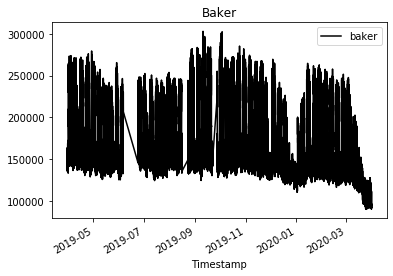

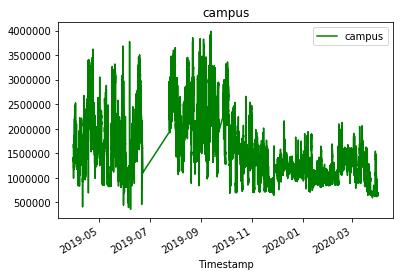

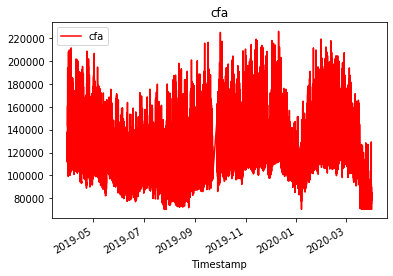

In [9]:
data_baker.plot(x='Timestamp', y='baker', title = "Baker", color = "black")
data_campus.plot(x='Timestamp', y='campus', title = "campus", color = "green")
data_cfa.plot(x='Timestamp', y='cfa', title = "cfa", color = "red" )
#To visualize the cleaned up interpolated data on a zoomed in version please uncomment the line below
#data_baker[193000:220000].plot(x='Timestamp', y='baker', title = "Baker Cleaned Zoomed", color = "black")

### Create Load Curves

I now create a unit of analysis (i.e., the samples that I will be considering in the clustering and forecasting models). 

$e_{j,D,t} = \frac{l_{j,D,t}}{T_D}, T_D = \sum_{t=1}^{24}{l_{j,D,t}}$

Implemented this equation, and created load curves for each building on campus. 

Firstly, all cleaned data is merged together.
Then, then for each of the building data, the data is marked and plotted based on the weekday.
Finally, to create load curves, the data is marked using the "Day of Year" and "Hour of Day", mean energy consumtions are calculated for each hour for each day and the load curve is generated.
(The influence of COVID-19 on energy consumption can clearly be seen after day 70 in the plots)

In [10]:
#merging cleaned datas
df = mergeall(data_baker, data_campus, data_cfa)

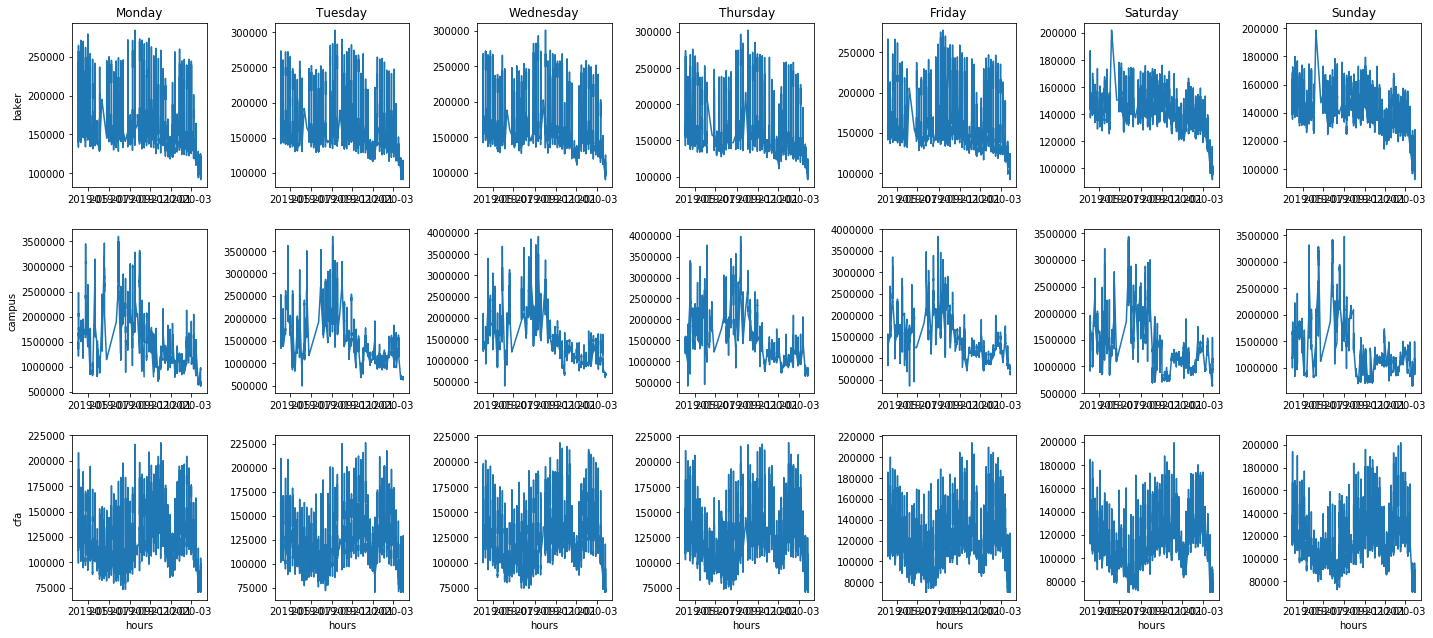

In [11]:
week_days = np.array([x.to_pydatetime().weekday() for x in df['Timestamp']])

Monday = df.iloc[week_days == 0]
Tuesday = df.iloc[week_days == 1]
Wednesday = df.iloc[week_days == 2]
Thursday = df.iloc[week_days == 3]
Friday = df.iloc[week_days == 4]
Saturday = df.iloc[week_days == 5]
Sunday = df.iloc[week_days == 6]

All = [Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]

pointNames = np.array(["baker","campus","cfa"])
#print('There are {} unique buildings.'.format(pointNames.shape[0]))

Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig = plt.figure(figsize=(20,20))
for i in range(len(pointNames)):
    for j in range(7): # iterate over days of the week
            plt.subplot(7,7,i*7+j+1)
            # Data from the day being plotted = All[j]
            # Data from the meter being plotted = All[j][All[j]['Point_name']==pointNames[i]]
            time = np.array(All[j]['Timestamp'])
            # plot the power vs the hours in a day
            plt.plot(time,All[j][pointNames[i]])
            if i==2:
                plt.xlabel('hours')
            if j==0: 
                plt.ylabel(pointNames[i])
            if i==0:
                plt.title(Days[j])
fig.tight_layout()
plt.show()

data = df
data['Hour'] = data['Timestamp'].dt.hour
data['Weekday'] = data['Timestamp'].dt.dayofweek
data['DayOfYear'] = data['Timestamp'].dt.dayofyear

In [12]:
#array to store each load curve table
loadcurve = []
for i in range(len(pointNames)):
    loadcurve.append(data.groupby(['DayOfYear', 'Hour'])[pointNames[i]].mean().unstack())
    
#Store Info just about the weekends
#loadweekends = []
#dataweekends = data[data['Weekday'] >= 5]
#for i in range(3):
    #loadweekends.append(dataweekends.groupby(['DayOfYear', 'Hour'])[pointNames[i]].mean().unstack())
    #plt.plot(np.mean(loadcurve[i],axis=0))
    #plt.plot(np.mean(loadweekends[i],axis=0))

loadcurve_baker = loadcurve[0]
loadcurve_campus = loadcurve[1]
loadcurve_cfa = loadcurve[2]

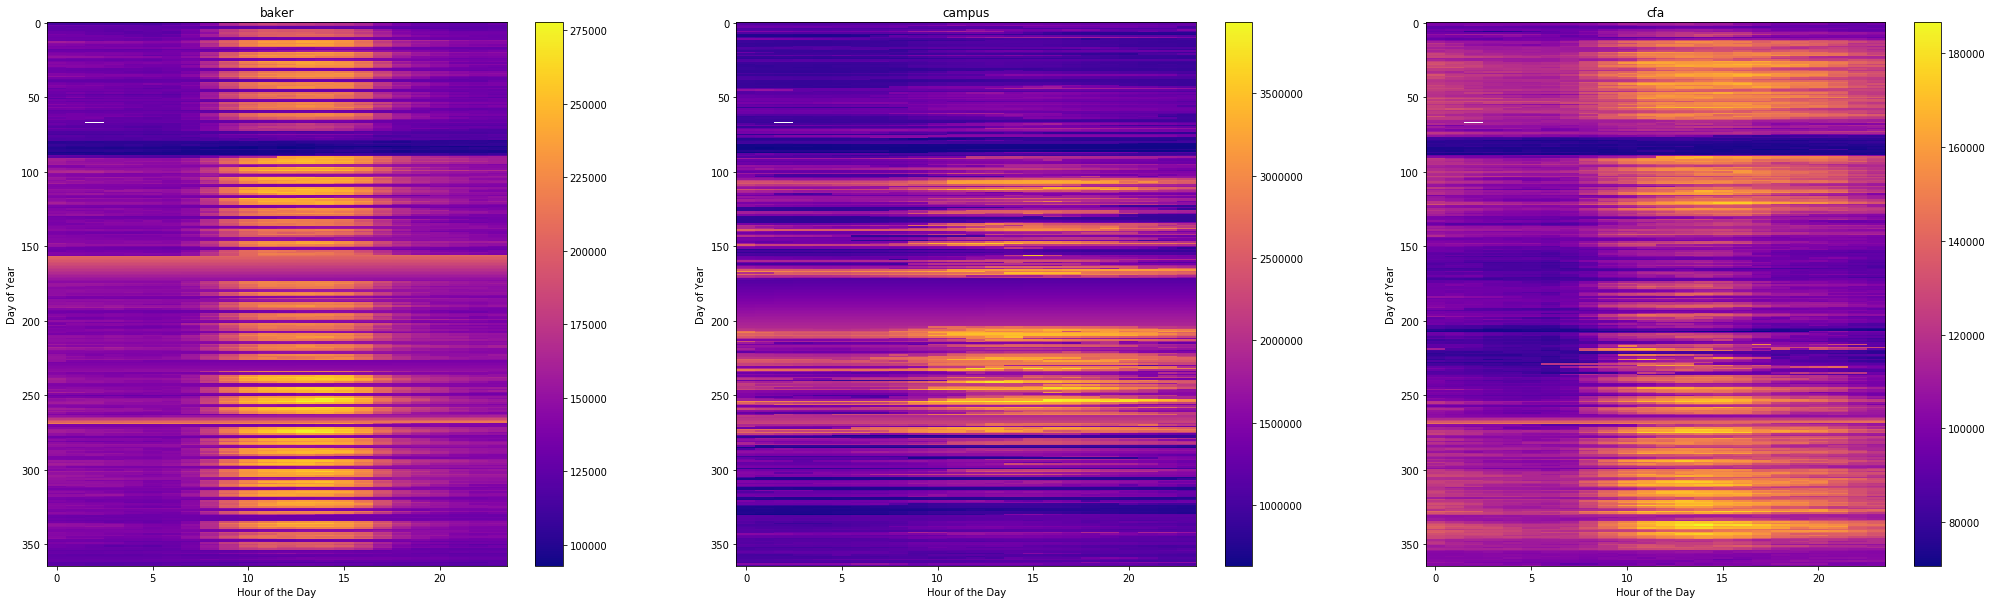

In [13]:
import matplotlib.colors as clrs
fig = plt.figure(figsize=(35,10))
for i in range(len(pointNames)):
#heat maps of load curves
    plt.subplot(1,3,i+1)
    plt.imshow(loadcurve[i], aspect='auto',cmap='plasma')
    plt.ylabel('Day of Year')
    plt.xlabel('Hour of the Day')
    plt.title(pointNames[i])
    plt.colorbar()
plt.show()

### Clustering the Data

For each of the meters in the dataset, I then ran a k-Means algorithm on the load curves with $k=3$. 

K means clustering method uses the similarity as the guiding metric for making decisions about segmentation, a general definition of dis-similarity (from here on dissimilarity) between any two pair of datapoints 
as $d_j(x_{ij},x_{i'j})$  and the a matrix $D \in R^{n\times n}$ nof dissimilarity values for every pair of data points can be defined as follows: $D(x_i, x_{i'}) = \sum_{j=1}^{p}{d_j(x_{ij},x_{i'j})}$

A very common choice of this dissimilarity measure (or distance measure) is the squared distance: $d_j(x_{ij},x_{i'j})=(x_{ij} - x_{i'j})^2$

which leads to a matrix that contains the Euclidean distance.
These have been implemented in the K-means function imported from sklearn.cluster

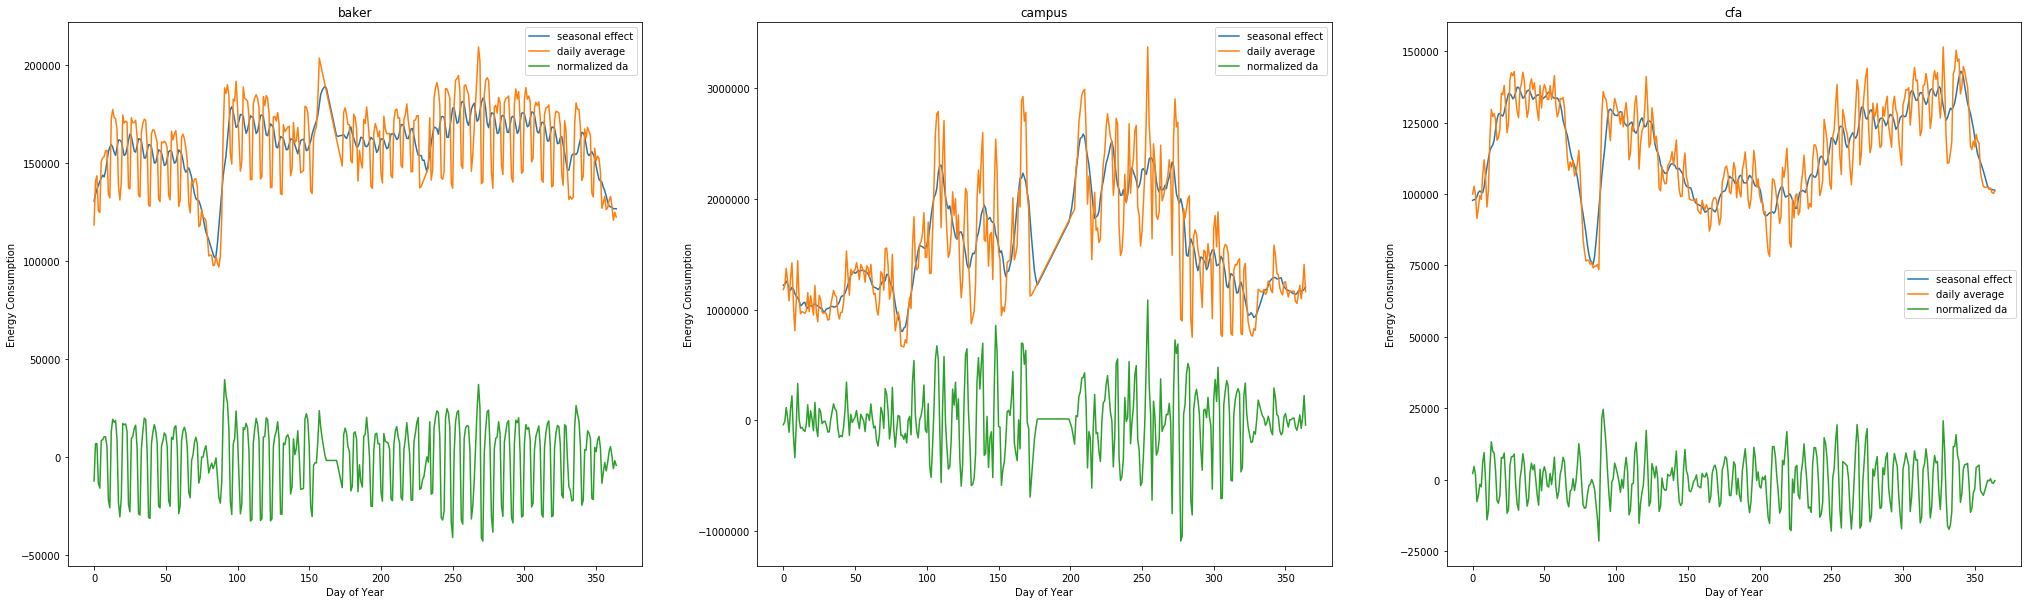

In [14]:
# First, Normalize the data
X = [] #(3, 365, 24)
for i in range(len(loadcurve)):
    loadcurve[i] = loadcurve[i].replace(np.inf, np.nan).fillna(0)
    X.append(loadcurve[i].to_numpy())
#here I compute a naive low-pass over 5 days
lp = 5
def find_avg(X,lp):
    avg = []
    for i in range((len(X))):
        avg.append(np.mean(X[np.max([i-lp,0]):i+lp,:]))
    return avg
baker_avg = find_avg(X[0],lp)
campus_avg = find_avg(X[1],lp)
cfa_avg = find_avg(X[2],lp)

#plot avg
fig = plt.figure(figsize=(35,10))
for i in range(len(X)):
    plt.subplot(1,3,i+1)
    plt.plot(find_avg(X[i],lp), label='seasonal effect')
    plt.plot(np.mean(X[i],axis=1), label='daily average')
    X[i] = (X[i].T - find_avg(X[i],lp)).T
    plt.plot(np.mean(X[i],axis=1), label='normalized da')
    plt.legend()
    plt.ylabel('Energy Consumption')
    plt.xlabel('Day of Year')
    plt.title(pointNames[i])
plt.show()

# Finding the dissimilarity matrix (Not used)
#import scipy.spatial.distance as dist
#for i in range(len(X)):
#    D = dist.squareform(dist.pdist(X[i]),'euclidean')

clusters = [0]*3
# Find the clusters, by default random_state uses the global random state from numpy.random.
for i in range(len(X)):
    clusters[i] = KMeans(n_clusters=3, random_state = np.random.seed()).fit(X[i])

num_clust = 3
cluster_assignments_baker = clusters[0].predict(X[0])
cluster_assignments_campus = clusters[1].predict(X[1])
cluster_assignments_cfa = clusters[2].predict(X[2])

cluster_assignments = [cluster_assignments_baker, cluster_assignments_campus, cluster_assignments_cfa]


### Observation

It can be observed that since March (60th Day in year), the campus energy consumption dropped significantly.

Number of Days in State 0 cluster in baker are 209
Number of Days in State 1 cluster in baker are 99
Number of Days in State 2 cluster in baker are 57
Number of Days in State 0 cluster in campus are 72
Number of Days in State 1 cluster in campus are 237
Number of Days in State 2 cluster in campus are 56
Number of Days in State 0 cluster in cfa are 125
Number of Days in State 1 cluster in cfa are 103
Number of Days in State 2 cluster in cfa are 137


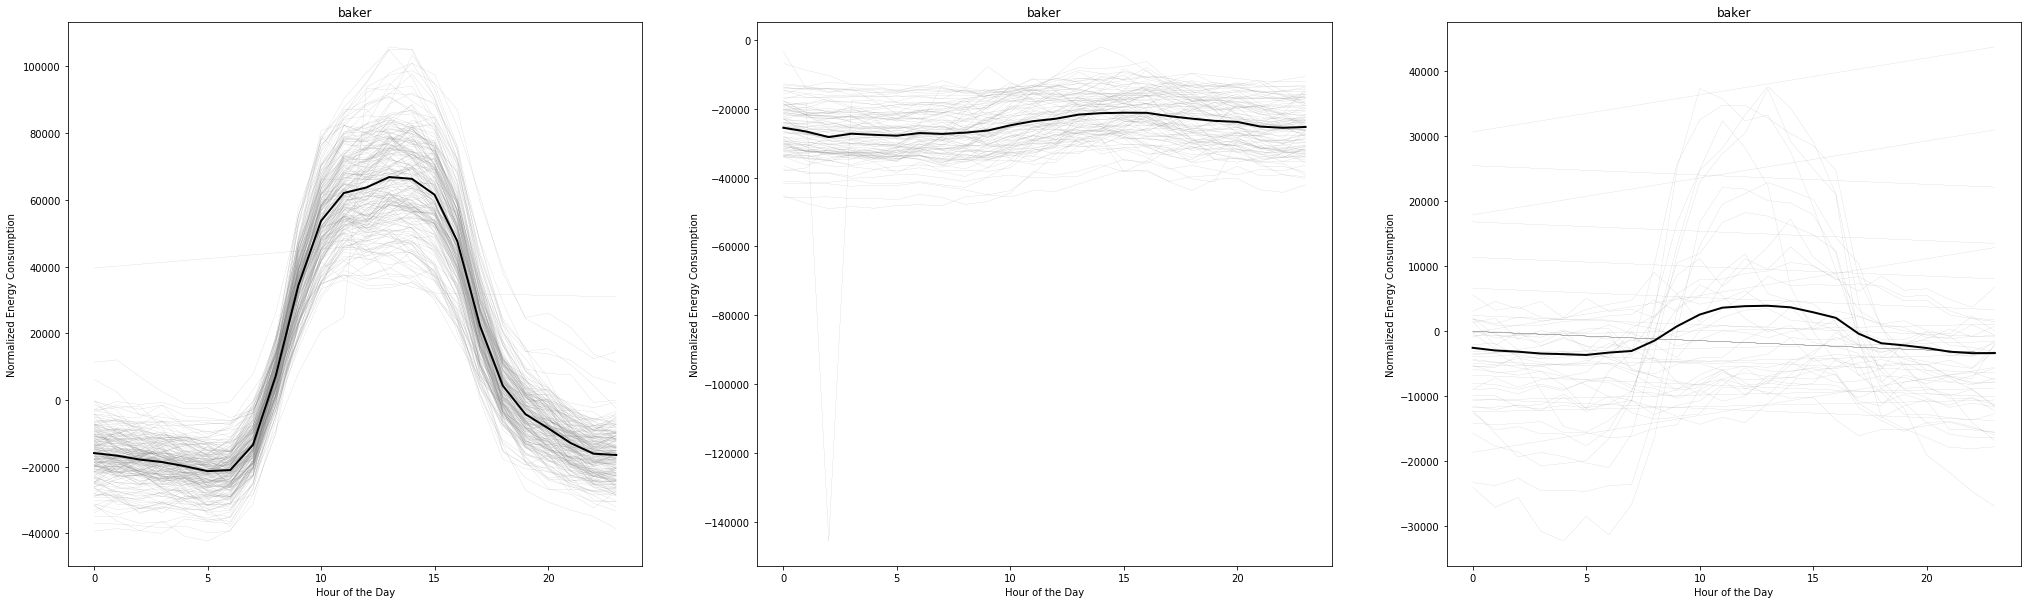

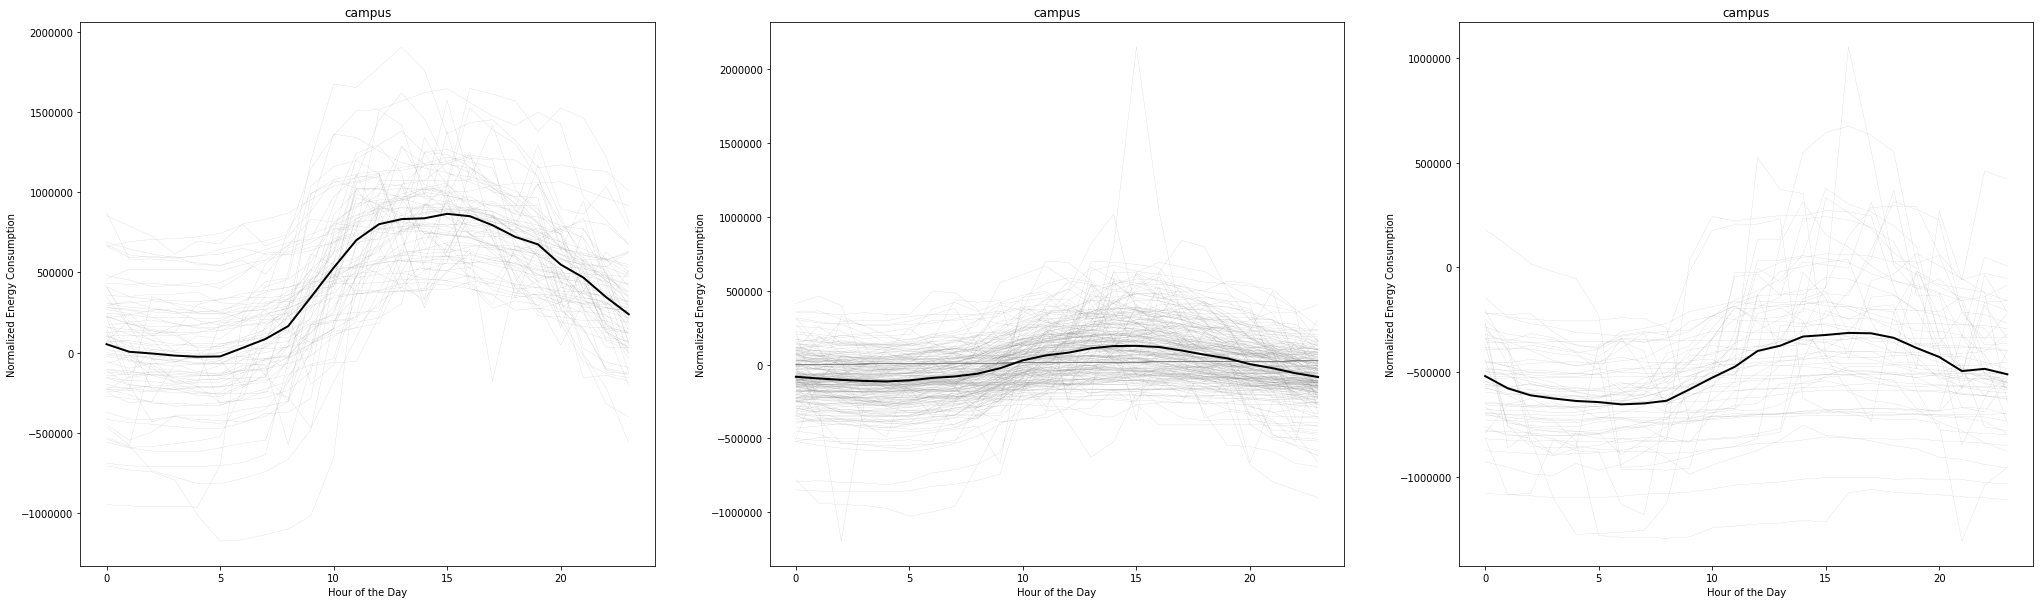

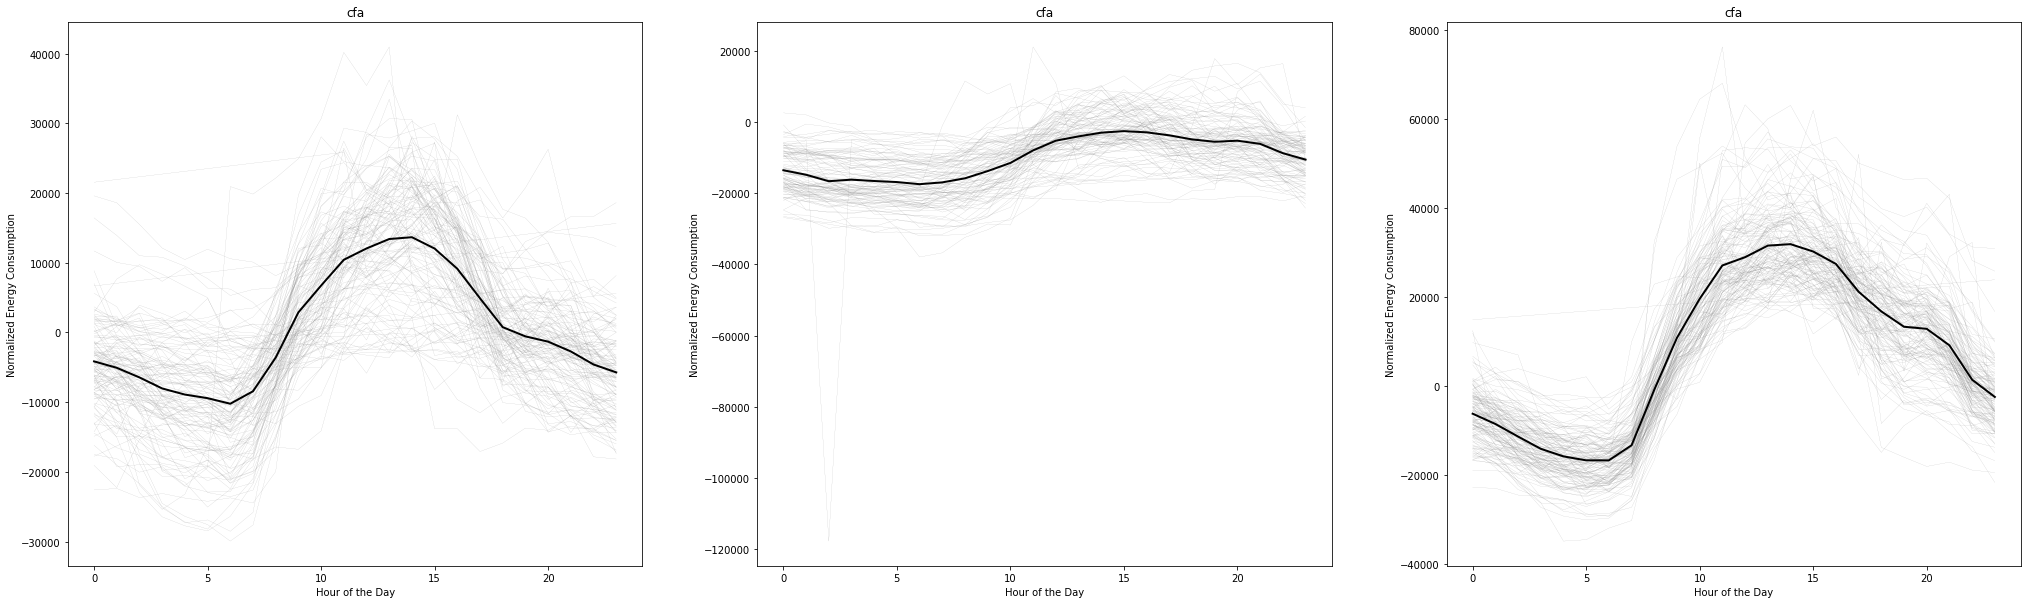

In [15]:
#Plotting the clusters for each of the building data.
#It is observed that clusters with close to linear line (also corresponding to the linear part of 
# other clusters of same building for example -25000 in baker), and having a average of 100 days 
#(close to the weekends in a year) like clusters State 1 in baker capture the energy consumption 
# trend on weekends, which is nearly constant.
# Whereas, the cluster with a sharp rise in energy consumption during the peek school hours (9am-4pm)
# correspond to the energy usage trend during the weekdays.

for i in range (len(X)):
    fig = plt.figure(figsize=(35,10))
    for cluster_id in range(len(clusters[i].cluster_centers_)):
        plt.subplot(1,num_clust,cluster_id+1)
        cluster_members = X[i][cluster_assignments[i]==cluster_id,:]
        #cluster_members_weekends = cluster_members[cluster_members['Weekday']==6,:]
        print('Number of Days in State {} cluster in {} are {}'.format(cluster_id,pointNames[i],len(cluster_members)))
        #print('Number of Weekend Days in State {} cluster in {} are {}'.format(cluster_members_weekends,cluster_id,pointNames[i],len(cluster_members)))
        for j in range(len(cluster_members)):
            plt.plot(cluster_members[j,:], color='grey', lw='0.1')
        plt.plot(clusters[i].cluster_centers_[cluster_id,:], color='k', lw='2')
        plt.ylabel('Normalized Energy Consumption')
        plt.xlabel('Hour of the Day')
        plt.title(pointNames[i])